First, let's define what propensity score matching is and why it's useful for data analysis. Propensity score matching is a method which matches similar observations from a control group to those in a treatment group. A probability of being assigned to the treatment group based on known confounding variables is calculated for each observation and then used for matching. Based on this definition, it's important to understand how this probability is calculated and how observations are matched. Although the probability can be calculated in different ways, a common and easy to implement method is logistic regression, which will be used for the purpose of this overview.

**The form of the logistic regression equation is as follows:**
<br>$\text{logit}(P(\text{Treatment} = 1)) = \beta_0 + \sum_{j=1}^{k} \beta_j X_{ij}$.

**The probability is calculated as:**
<br>$
P(\text{Treatment} = 1) = \frac{1}{1 + \exp\left(-\left(\beta_0 + \sum_{j=1}^{k} \beta_j X_{ij}\right)\right)}
$

Now that the method has been defined and a method for calculating probability identified, it's necessary to define a criteria for record matching. There are multiple approaches available including:
- _Matching on N nearest neighbors_
- _Matching with a probability caliper_
- _Matching with a logit caliper_

Both logit and probability caliper matching methods involve setting a pre-defined range in which one or more observations from the control group is matched to the treatment group. Although they will likely produce similar results, the result will not be identical as the transformation from the logit to probability is non-linear. N nearest neighbor matching involves defining a number of neighbors $( \geq 1 )$ from the treatment group to match to the control group based on similarity of probability of being assigned to the treatment group. 

The key difference between these approaches is N nearest neighbor matching will only match the pre-specified number of neighbors which are closest in probability while probability and logit matching will match any number of neighbors which are within the caliper range.

For this overview the Lalonde dataset will be used (https://search.r-project.org/CRAN/refmans/designmatch/html/lalonde.html). This is a commonly used dataset to illustrate and test propensity score matching methods and contains 9 variables as well as an additional treatment indicator variable which denotes whether a record received treatment.


In [37]:
# -- import libraries

import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 39, Finished, Available, Finished)

In [38]:
# -- import data

url = "https://github.com/seshghipour1/Propensity-Score-Matching-Overview/blob/main/Dataset/lalonde.csv?raw=true"
df  = pd.read_csv(url)
df.head(5)

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 40, Finished, Available, Finished)

,treatment,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [39]:
# -- assign correct data types

df['black']     = df['black'].astype('category')
df['hispanic']  = df['hispanic'].astype('category')
df['married']   = df['married'].astype('category')
df['nodegree']  = df['nodegree'].astype('category')

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 41, Finished, Available, Finished)

For the purpose of this overview, N nearest neighbor matching will be utilized.

<u>The PSM algorithm follows these steps:
</u>
\begin{array}{|c|l|}
\hline
\textbf{Step} & \textbf{Description} \\
\hline
1 & \text{Create model: } \texttt{glm(Treatment \texttt{\textasciitilde} Xi, family = binomial)} \\
\hline
2 & \text{Extract propensity scores} \\
\hline
3 & \text{Match based on N nearest neighbors} \\
\hline
\end{array}

#### Step 1. Create model - Treatment ~ Xi

A logistic regression model is used to calculate the likelihood of a record being in the treatment group.

In [40]:
df['treatment'] = pd.Categorical(df['treatment'], categories=[1, 0], ordered=False)

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 42, Finished, Available, Finished)

In [41]:
# -- model

psm_model = smf.glm(formula="treatment ~ age + education + black + hispanic + married + nodegree + re74 + re75 + re78", data=df, family=sm.families.Binomial()).fit()
print(psm_model.summary())

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 43, Finished, Available, Finished)

                        Generalized Linear Model Regression Results                         
Dep. Variable:     ['treatment[1]', 'treatment[0]']   No. Observations:                  614
Model:                                          GLM   Df Residuals:                      604
Model Family:                              Binomial   Df Model:                            9
Link Function:                                Logit   Scale:                          1.0000
Method:                                        IRLS   Log-Likelihood:                -242.58
Date:                              Tue, 18 Feb 2025   Deviance:                       485.15
Time:                                      17:02:03   Pearson chi2:                     562.
No. Iterations:                                   6   Pseudo R-squ. (CS):             0.3519
Covariance Type:                          nonrobust                                         
                    coef    std err          z      P>|z|      [0.025 

#### Step 2: Extract propensity scores
Probability scores are calculated for all records.

In [42]:
# -- extract

df['propensity_score'] = psm_model.predict(df).values

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 44, Finished, Available, Finished)

#### Step 3: Match based on propensity scores using Caliper Matching
Matching is done based on N nearest neighbors. Given the small size of this dataset (185 treated and 260 control observations), N=1 neighbor matching is a sensible choice. With any larger value of N the size of the control group will remain unchanged.

In [43]:
# -- match

# define control and treatment dataframes
control_df   = df[df['treatment'] == 0]
treatment_df = df[df['treatment'] == 1]

# initialize
keep_list    = list()
used_indices = set()
N = 1

# loop
for index, row in treatment_df.iterrows():

    # filter control df to matched records
    control_df = control_df[~control_df.index.isin(used_indices)]

    # compare
    propscore = row['propensity_score'] # get propensity score from treatment_df
    control_df.loc[:, 'diff'] = abs(control_df['propensity_score'] - propscore)

    # get nearest neighbor rows and their indices
    nn = control_df.nsmallest(N, 'diff') # 1 neighbor closest in value
    nn_indices = nn.index.tolist()

    # update
    keep_list.extend(nn_indices)
    used_indices.update(nn_indices)

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 45, Finished, Available, Finished)

In [44]:
# -- filter dataframe to observations that received treatment or those which were matched

filtered_df = df[(df['treatment'] == 1) | (df.index.isin(keep_list))]
filtered_df

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 46, Finished, Available, Finished)

,treatment,age,education,black,hispanic,married,nodegree,re74,re75,re78,propensity_score
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.665675
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.211310
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.785221
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.787978
4,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.679669
...,...,...,...,...,...,...,...,...,...,...,...
608,0,25,14,0,0,0,0,0.0,0.0,0.0000,0.092448
609,0,18,11,0,0,0,1,0.0,0.0,10150.5000,0.136146
611,0,21,18,0,0,0,0,0.0,0.0,0.0000,0.148294
612,0,32,5,1,0,1,1,0.0,0.0,187.6713,0.363995


## Plot distribution of propensity scores

When plotting the propensity scores side by side, it is clear that propensity score matching brought the values for control and treatment much closer than they were in the original dataset. This chart highlights the efficacy of the method as the two groups are now more similar in probability of treatment assignment than they were previously. The **unmatched** data is displayed on the left-hand side while the **matched** data is displayed on the right-hand side.

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 47, Finished, Available, Finished)

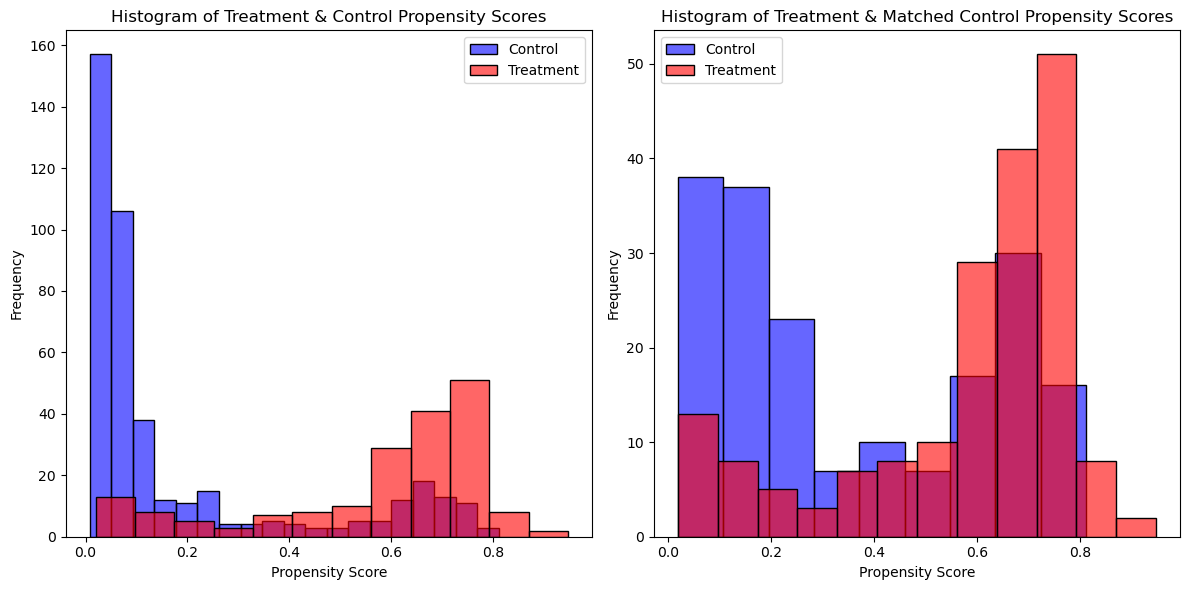

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# initialize
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# -- Plot histogram of treatment and all control observation propensity scores
sns.histplot(data=df[df['treatment'] == 0], x='propensity_score', color='blue', label='Control', fill=True, alpha=0.6, ax=axes[0])
sns.histplot(data=df[df['treatment'] == 1], x='propensity_score', color='red', label='Treatment', fill=True, alpha=0.6, ax=axes[0])
axes[0].set_title('Histogram of Treatment & Control Propensity Scores')
axes[0].set_xlabel('Propensity Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# -- Plot histogram of treatment and matched control observation propensity scores
sns.histplot(data=filtered_df[filtered_df['treatment'] == 0], x='propensity_score', color='blue', label='Control', fill=True, alpha=0.6, ax=axes[1])
sns.histplot(data=filtered_df[filtered_df['treatment'] == 1], x='propensity_score', color='red', label='Treatment', fill=True, alpha=0.6, ax=axes[1])
axes[1].set_title('Histogram of Treatment & Matched Control Propensity Scores')
axes[1].set_xlabel('Propensity Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# display
plt.tight_layout()
plt.show()

### Exploring the impact of using PSM on variable distributions

In order to view the efficacy of the method in terms of variable distributions, a standardized mean difference is calculated for all numeric and binary variables. A successful propensity score matching between treatment and control should show that the difference between control adjusted and treatment is smaller than the difference between control unadjusted and treatment. This tightening of distributions is demonstrated in the chart below.

**Cohens d for mean difference:**
<br>
$d=\frac{\mu_{\text{trt}} - \mu_{\text{ctrl}}}{\sqrt{\frac{(n_{\text{trt}} - 1) \sigma_{\text{trt}}^2 + (n_{\text{ctrl}} - 1) \sigma_{\text{ctrl}}^2}{n_{\text{trt}} + n_{\text{control}} - 2}}} $
</br>

**Cohens h for difference in proportions:**
<br>
$h = 2 \cdot \left( \arcsin \left( \sqrt{p_1} \right) - \arcsin \left( \sqrt{p_2} \right) \right)$
</br>

In [46]:
# - define numerical and categorical variable lists
numeric_vars = df.select_dtypes(include=['number']).columns.tolist()
binary_vars  = df.select_dtypes(include=['category']).columns.tolist()
numeric_vars.remove('propensity_score') # exclude propensity score
binary_vars.remove('treatment')    # exclude the treatment variable


# - get number of observations
n_treatment        = len(df[df['treatment']==1])
n_control_adjusted = len(filtered_df[filtered_df['treatment']==0])
n_control          = len(df[df['treatment']==0])

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 48, Finished, Available, Finished)

In [47]:
# -- calculate for numeric vars

results_list_num = []

# Get number of observations for each group
n_treatment = len(df[df['treatment'] == 1])
n_control_adjusted = len(filtered_df[filtered_df['treatment'] == 0])
n_control = len(df[df['treatment'] == 0])

for var in numeric_vars:

    # get treatment unadjusted calculations
    mean_treatment = np.mean(df[df['treatment'] == 1][var])
    stdv_treatment = np.std(df[df['treatment'] == 1][var])
    
    # get control adjusted calculations
    mean_control_adjusted = np.mean(filtered_df[filtered_df['treatment'] == 0][var])
    stdv_control_adjusted = np.std(filtered_df[filtered_df['treatment'] == 0][var])

    # get control calculations
    mean_control = np.mean(df[df['treatment'] == 0][var])
    stdv_control = np.std(df[df['treatment'] == 0][var])

    # - calculate standardized mean difference
    # get mean differences
    meandiff_treatmentvscontrol = mean_treatment - mean_control
    meandiff_treatmentvscontroladjusted = mean_treatment - mean_control_adjusted

    # get pooled standard deviations
    pooledstdev_treatmentvscontrol = np.sqrt(
        ((n_treatment - 1) * stdv_treatment ** 2 + (n_control - 1) * stdv_control ** 2) 
        / (n_treatment + n_control - 2)
    )

    pooledstdev_treatmentvscontroladjusted = np.sqrt(
        ((n_treatment - 1) * stdv_treatment ** 2 + (n_control_adjusted - 1) * stdv_control_adjusted ** 2) 
        / (n_treatment + n_control_adjusted - 2)
    )

    # cohen's d
    d = meandiff_treatmentvscontrol / pooledstdev_treatmentvscontrol
    d_adjusted = meandiff_treatmentvscontroladjusted / pooledstdev_treatmentvscontroladjusted

    # append as dictionary
    results_list_num.append({
        'var': var,
        'mean_treatment': mean_treatment,
        'stdv_treatment': stdv_treatment,
        'mean_control_adjusted': mean_control_adjusted,
        'stdv_control_adjusted': stdv_control_adjusted,
        'mean_control': mean_control,
        'stdv_control': stdv_control,
        'effect_size': d,
        'effect_size_adjusted': d_adjusted
    })

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 49, Finished, Available, Finished)

In [48]:
binary_vars

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 50, Finished, Available, Finished)

['black', 'hispanic', 'married', 'nodegree']

In [49]:
## -- calculate for binary variables
results_list_cat = []

for var in binary_vars:

    # get proportions for treatment unadjusted
    proportion_treatment = sum(df[df['treatment'] == 1][var]) / n_treatment
    stdev_treatment = np.sqrt(proportion_treatment * (1 - proportion_treatment) / n_treatment)

    # get proportions for control adjusted
    proportion_control_adjusted = sum(filtered_df[filtered_df['treatment'] == 0][var]) / n_control_adjusted
    stdev_control_adjusted = np.sqrt(proportion_control_adjusted * (1 - proportion_control_adjusted) / n_control_adjusted)
    
    # get proportions for control
    proportion_control = sum(df[df['treatment'] == 0][var]) / n_control
    stdev_control = np.sqrt(proportion_control * (1 - proportion_control) / n_control)

    # cohen's h
    h = 2 * (np.arcsin(np.sqrt(proportion_treatment)) - np.arcsin(np.sqrt(proportion_control)))
    h_adjusted = 2 * (np.arcsin(np.sqrt(proportion_treatment)) - np.arcsin(np.sqrt(proportion_control_adjusted)))

    # Append results to the list
    results_list_cat.append({
        'var': var,
        'mean_treatment': proportion_treatment,
        'stdv_treatment': stdev_treatment,
        'mean_control_adjusted': proportion_control_adjusted,
        'stdv_control_adjusted': stdev_control_adjusted,
        'mean_control': proportion_control,
        'stdv_control': stdev_control,
        'effect_size': h,
        'effect_size_adjusted': h_adjusted
    })

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 51, Finished, Available, Finished)

In [50]:
# - create dataframes
results_df_numeric = pd.DataFrame(results_list_num)     # numeric vars
results_df_categorical = pd.DataFrame(results_list_cat) # categorical vars

# - concatenate to one dataframe
results_df = pd.concat([results_df_numeric,results_df_categorical])

results_df

StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 52, Finished, Available, Finished)

,var,mean_treatment,stdv_treatment,mean_control_adjusted,stdv_control_adjusted,mean_control,stdv_control,effect_size,effect_size_adjusted
0,age,25.816216,7.135655,24.929730,10.287775,28.030303,10.774074,-0.225401,0.100133
1,education,10.345946,2.005209,10.454054,2.613747,10.235431,2.851909,0.042082,-0.046410
2,re74,2095.573689,4873.395375,2444.434180,4454.690911,5619.236506,6780.833883,-0.562107,-0.074723
3,re75,1532.055314,3210.538402,1663.858034,2654.516724,2466.484443,3288.157119,-0.286194,-0.044744
4,re78,6349.143530,7846.110156,6360.838042,6423.054632,6984.169742,7285.655477,-0.085140,-0.001631
0,black,0.843243,0.026730,0.470270,0.036696,0.202797,0.019413,1.393172,0.816141
1,hispanic,0.059459,0.017387,0.205405,0.029702,0.142191,0.016862,-0.280635,-0.448088
2,married,0.189189,0.028795,0.200000,0.029409,0.512821,0.024132,-0.696455,-0.027310
3,nodegree,0.708108,0.033425,0.675676,0.034417,0.596737,0.023684,0.234579,0.070266


StatementMeta(, 413c2aa6-e1bf-478b-8ede-999ba76903be, 53, Finished, Available, Finished)

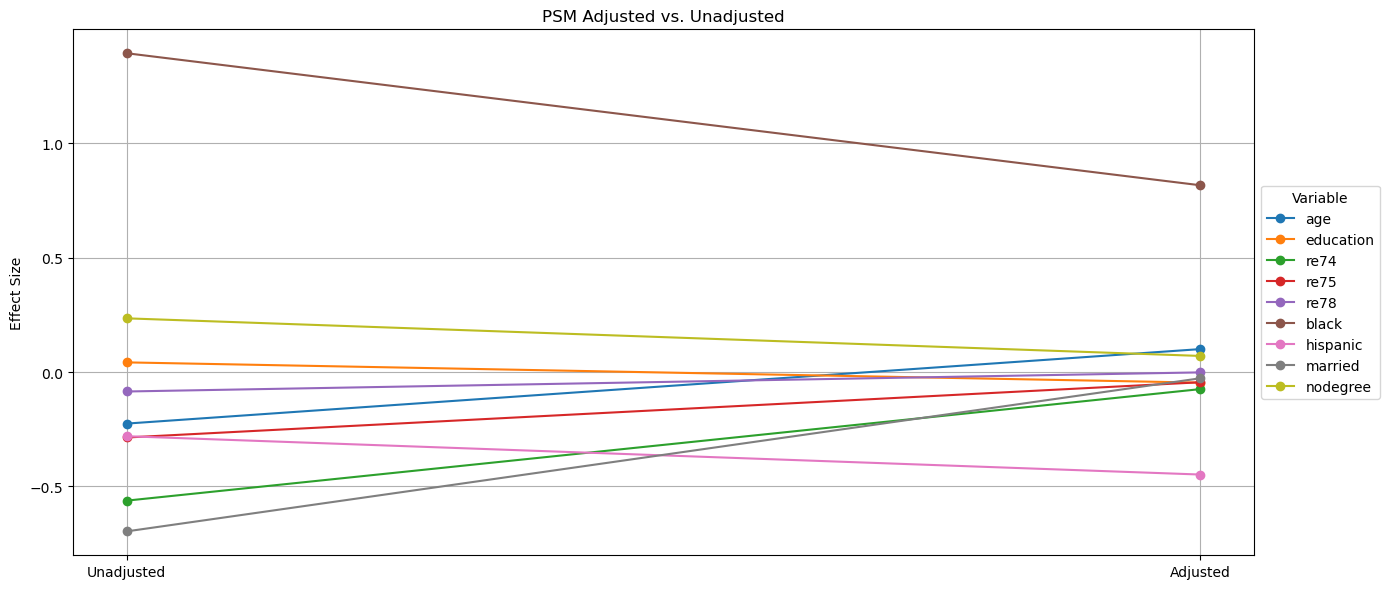

In [51]:
# -- plot the change in effect size

plt.figure(figsize=(14, 6))

for index, row in results_df.iterrows():
    plt.plot([0, 1], [row['effect_size'], row['effect_size_adjusted']], marker='o', label=row['var'])

plt.ylabel('Effect Size')
plt.xticks([0, 1], ['Unadjusted', 'Adjusted'])
plt.title('PSM Adjusted vs. Unadjusted')
plt.legend(title='Category', loc='best')
plt.grid(True)

plt.legend(title='Variable', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.show()